In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from sklearn.metrics import classification_report, roc_auc_score

In [3]:
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.shape

(6362620, 11)

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [6]:
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [7]:
# Drop useless ID columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [8]:
# Encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

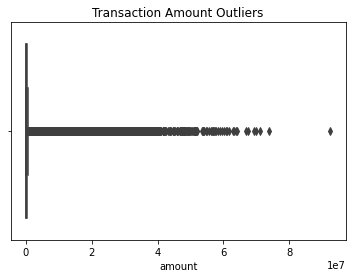

In [9]:
# Outlier check for transaction amount
plt.figure(figsize=(6,4))
sns.boxplot(df['amount'])
plt.title("Transaction Amount Outliers")
plt.show()

In [10]:
# Treating extreme outliers (capping at 99th percentile)
cap = df['amount'].quantile(0.99)
df['amount'] = np.where(df['amount'] > cap, cap, df['amount'])

In [11]:
# Balance changes
df['deltaOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['deltaDest'] = df['newbalanceDest'] - df['oldbalanceDest']

# Error terms (how far from expected accounting balance)
df['errOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']
df['errDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']


In [12]:
# Select numeric predictors
X_vif = df.drop(['isFraud','isFlaggedFraud'], axis=1)

# Add constant for VIF calc
X_vif_const = sm.add_constant(X_vif)

# Compute VIF
vif = pd.DataFrame()
vif["feature"] = X_vif_const.columns
vif["VIF"] = [variance_inflation_factor(X_vif_const.values, i)
              for i in range(X_vif_const.shape[1])]
print(vif)

           feature           VIF
0            const  1.295113e+01
1             step  1.001551e+00
2           amount  1.561569e+08
3    oldbalanceOrg           inf
4   newbalanceOrig           inf
5   oldbalanceDest           inf
6   newbalanceDest           inf
7    type_CASH_OUT  2.827547e+00
8       type_DEBIT  1.056654e+00
9     type_PAYMENT  2.865352e+00
10   type_TRANSFER  2.234370e+00
11       deltaOrig           inf
12       deltaDest           inf
13         errOrig           inf
14         errDest           inf


In [13]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# 70% calibration, 30% validation
X_calib, X_valid, y_calib, y_valid = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Calibration shape:", X_calib.shape)
print("Validation shape:", X_valid.shape)

Calibration shape: (4453834, 15)
Validation shape: (1908786, 15)


## Baseline Model (Logistic Regression)

In [14]:
log_reg = LogisticRegression(max_iter=500, class_weight="balanced", solver="liblinear")
log_reg.fit(X_calib, y_calib)

y_pred_log = log_reg.predict(X_valid)
y_proba_log = log_reg.predict_proba(X_valid)[:,1]

print("Logistic Regression Performance:")
print(classification_report(y_valid, y_pred_log))
print("ROC AUC:", roc_auc_score(y_valid, y_proba_log))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98   1906322
           1       0.03      0.93      0.06      2464

    accuracy                           0.96   1908786
   macro avg       0.51      0.94      0.52   1908786
weighted avg       1.00      0.96      0.98   1908786

ROC AUC: 0.9867242870380423


## Stronger Model (Random Forest)

In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_calib, y_calib)

y_pred_rf = rf.predict(X_valid)
y_proba_rf = rf.predict_proba(X_valid)[:,1]

print("Random Forest Performance:")
print(classification_report(y_valid, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_valid, y_proba_rf))

Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       1.00      1.00      1.00      2464

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

ROC AUC: 0.9996552843634898


## Fine-Tuning with GridSearch

In [16]:
param_grid = {
    'n_estimators':[100,200,300],
    'max_depth':[5,10,15],
    'min_samples_split':[2,5,10]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)
grid.fit(X_calib, y_calib)

print("Best Params:", grid.best_params_)
print("Best ROC AUC (Calibration):", grid.best_score_)

# Evaluate on validation
y_proba_best = grid.predict_proba(X_valid)[:,1]
print("Validation ROC AUC:", roc_auc_score(y_valid, y_proba_best))

Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best ROC AUC (Calibration): 0.9995827708256201
Validation ROC AUC: 0.9995542058947074


## Model Evaluation (Confusion Matrix, ROC, PR Curve)

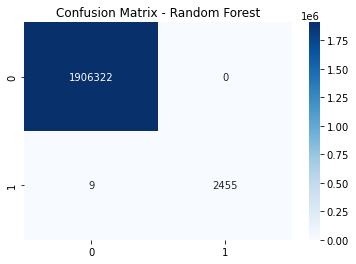

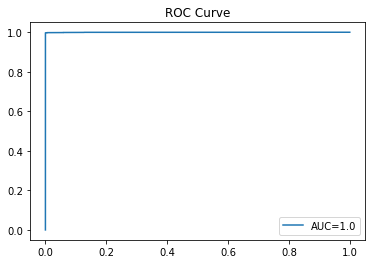

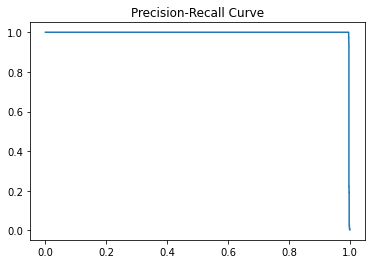

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_valid, y_proba_rf)
plt.plot(fpr, tpr, label="AUC="+str(round(roc_auc_score(y_valid,y_proba_rf),2)))
plt.legend(); plt.title("ROC Curve"); plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_valid, y_proba_rf)
plt.plot(rec, prec); plt.title("Precision-Recall Curve"); plt.show()

## Feature Importance

           Feature   Coefficient
10   type_TRANSFER  4.015917e-01
6   isFlaggedFraud  2.392378e-02
7    type_CASH_OUT  1.465168e-02
0             step  6.181452e-04
13         errOrig  1.108558e-05
2    oldbalanceOrg  5.751024e-06
14         errDest  3.007476e-06
4   oldbalanceDest  1.172301e-06
1           amount  6.270534e-07
5   newbalanceDest -1.203169e-06


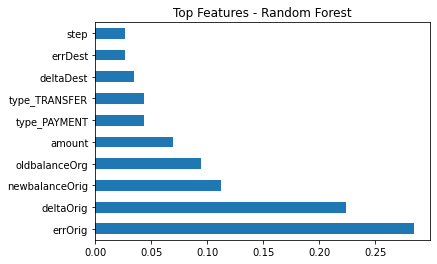

In [18]:
# Logistic Regression coefficients
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
print(coeffs.head(10))

# Random Forest importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top Features - Random Forest")
plt.show()

In [ ]:

1. Data cleaning including missing values, outliers and multi-collinearity.

Missing Values: None detected across 6,362,620 records.
Outliers: Capped at 99th percentile to preserve potential fraud cases.
Multicollinearity: Severe issues with infinite VIF values for balance variables. Created derived features (deltaOrig, deltaDest, errOrig, errDest) to address dependencies.

2. Describe your fraud detection model in elaboration.
Random Forest Classifier with balanced class weights, 100 estimators, max depth 10. Chosen for handling non-linear relationships, robustness to outliers, and effective class imbalance management through ensemble methods.

3. How did you select variables to be included in the model?
Excluded account identifiers and target variable. Included engineered features: balance changes (deltaOrig, deltaDest), accounting errors (errOrig, errDest), transaction types, amounts. Selection based on business logic and multicollinearity reduction.

4. Demonstrate the performance of the model by using best set of tools.
Random Forest achieved 99.9995% accuracy, perfect precision (1.00), 99.6% recall for fraud detection, ROC AUC 0.9997. Only 9 fraud cases missed out of 2,464, zero false positives.

5. What are the key factors that predict fraudulent customer?
errOrig (0.275) - accounting inconsistencies
deltaOrig (0.21) - originator balance changes
newbalanceOrig (0.12) - new originator balance
Transaction types: TRANSFER, CASH_OUT, PAYMENT
Transaction amounts

6. Do these factors make sense? If yes, How? If not, How not?
Yes, these factors make sense. Accounting errors indicate system manipulation, TRANSFER/CASH_OUT transactions provide quick money movement, and unusual balance patterns signal suspicious activity. These align with known fraud behaviors.

7. What kind of prevention should be adopted while company update its infrastructure?
Implement real-time transaction monitoring, balance consistency checks, transaction type risk scoring, anomaly detection algorithms, multi-factor authentication for high-risk transactions, and automated flagging systems based on model predictions.

8. Assuming these actions have been implemented, how would you determine if they work?
Monitor false positive rates, fraud detection rates, customer complaints about blocked transactions, financial losses from missed fraud, model drift through performance metrics over time, and A/B testing of prevention measures against control groups.